# Day 2, after lunch: Gridded data analysis and plotting
Focus: netCDF files

In [1]:
import netCDF4 as nc
f = nc.Dataset('d2s2/ei.ans.2010072912.800.T.nc', 'r')

In [2]:
print('Variables:', f.variables)
print('Attributes:', f.ncattrs())

Variables: OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (361,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 1900-01-01 00:00:00
    calendar: standard
unlimited dimensions: time
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('t', <class 'netCDF4._netCDF4.Variable'>
int16 t(time, latitude, longitude)
    long_name: Temperature
    units: K
    add_offset: 261.2217974783569
    s

In [3]:
temp = f.variables['t']
# Retrieving the variable object versus the data
print(type(temp), type(temp[:]))

<class 'netCDF4._netCDF4.Variable'> <class 'numpy.ma.core.MaskedArray'>


In [4]:
temp = temp[:]
print(temp.shape, temp.min(), temp.max())

(1, 361, 720) 215.71340664529046 306.56727771192055


Not actually super difficult, but may be there is an even simpler way?

In [5]:
import xarray as xr
f = xr.open_dataset('d2s2/ei.ans.2010072912.800.T.nc')
temp_var = f.variables['t']
t_da = f['t']
print(type(t_da),type(temp_var))
print(t_da)

<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.variable.Variable'>
<xarray.DataArray 't' (time: 1, latitude: 361, longitude: 720)>
[259920 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 2010-07-29T06:00:00
Attributes:
    long_name:  Temperature
    units:      K


Hardly any difference, when using ``f.variables['t']``, but ``f['t']`` has some nice extra features.

In [6]:
print(t_da.sel(latitude=60.5))
print(t_da.sel(latitude=60.5, longitude=5.5))

<xarray.DataArray 't' (time: 1, longitude: 720)>
array([[280.51224, 280.13464, 279.80426, ..., 281.72266, 281.3542 , 280.93246]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
    latitude   float32 60.5
  * time       (time) datetime64[ns] 2010-07-29T06:00:00
Attributes:
    long_name:  Temperature
    units:      K
<xarray.DataArray 't' (time: 1)>
array([280.1849], dtype=float32)
Coordinates:
    longitude  float32 5.5
    latitude   float32 60.5
  * time       (time) datetime64[ns] 2010-07-29T06:00:00
Attributes:
    long_name:  Temperature
    units:      K


And they can easily be saved to netCDF.

In [7]:
from datetime import datetime as dt
tosave = t_da.sel(time=dt(2010,7,29,6))
tosave.to_netcdf('example.nc')
!ls -l example.nc

-rw-r--r--  1 rewquey  staff  536651 Jan 20 12:56 example.nc


If you have ncdump available, you can also have a direct look at what we saved, and to verify that all metadata has automatically been transferred to the new netCDF file.

In [8]:
!ncdump -h example.nc

netcdf example {
dimensions:
	longitude = 720 ;
	latitude = 361 ;
variables:
	float longitude(longitude) ;
		longitude:_FillValue = NaNf ;
		longitude:standard_name = "longitude" ;
		longitude:long_name = "longitude" ;
		longitude:units = "degrees_east" ;
		longitude:axis = "X" ;
	float latitude(latitude) ;
		latitude:_FillValue = NaNf ;
		latitude:standard_name = "latitude" ;
		latitude:long_name = "latitude" ;
		latitude:units = "degrees_north" ;
		latitude:axis = "Y" ;
	double time ;
		time:_FillValue = NaN ;
		time:standard_name = "time" ;
		time:units = "hours since 1900-01-01" ;
		time:calendar = "standard" ;
	short t(latitude, longitude) ;
		t:_FillValue = -32767s ;
		t:long_name = "Temperature" ;
		t:units = "K" ;
		t:coordinates = "time" ;
		t:add_offset = 261.221797478357 ;
		t:scale_factor = 0.00152252896731571 ;
}


(-3600000.0, 3600000.0)

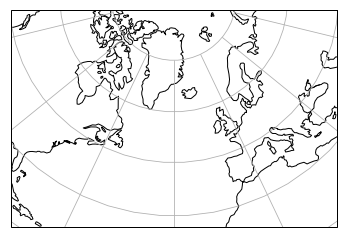

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Create a matplotlib axes using the Lambert Conic Conformal projection
proj = ccrs.LambertConformal(
    central_longitude=-30, 
    central_latitude=58, 
    standard_parallels=(58, 58)
)
ax = plt.axes(projection=proj)

# Add coastlines
ax.coastlines()
ax.gridlines(ylocs=range(15,76,15))

# set map domain by setting the x- and y-limits in meters
ax.set_xlim([-5.4e6, 5.4e6])
ax.set_ylim([-3.6e6, 3.6e6])

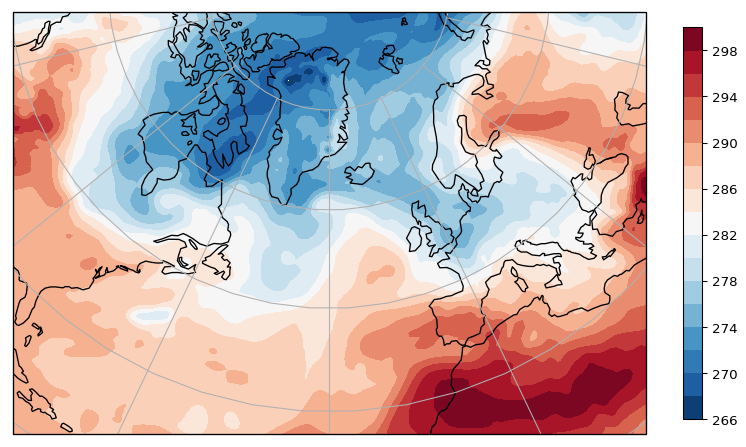

In [10]:
fig = plt.figure(figsize=(10.0,6.0), dpi=96) 
ax = plt.axes(projection=proj)

# A temperature map
showdate = t_da.time.values[0]
cs = ax.contourf(t_da.longitude, t_da.latitude, t_da.sel(time=showdate), 
            range(266,301,2),
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(), # the projection of the data grid, here lat/lon, i.e. PlateCarree
)
ax.coastlines()
ax.gridlines(ylocs=range(15,76,15))

ax.set_xlim([-5.4e6, 5.4e6])
ax.set_ylim([-3.6e6, 3.6e6])

plt.colorbar(cs, fraction=0.1, shrink=0.9)

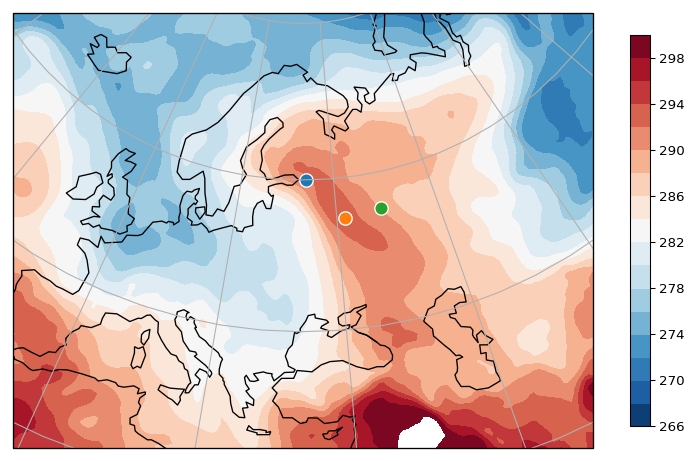

In [11]:
fig = plt.figure(figsize=(10.0,6.0), dpi=96) 

# new projection, centred on Moscow
proj = ccrs.LambertConformal(
    central_longitude=30, 
    central_latitude=55, 
    standard_parallels=(55, 55)
)

# obs and info from different places
stations = ['StPeter', 'Moscow', 'NizNovg']
stationnames = ['St. Petersburg', 'Moscow', 'Nizhny Novgorod']

# Plot map
ax = plt.axes(projection=proj) # Map axes covers everything but the rightmost column
cs = ax.contourf(t_da.longitude, t_da.latitude, t_da.sel(time=showdate), 
            range(266,301,2),
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(), # the projection of the data grid, here lat/lon, i.e. PlateCarree
)
ax.coastlines()
ax.gridlines(ylocs=range(15,76,15))

ax.set_xlim([-3.2e6, 3.2e6])
ax.set_ylim([-2.4e6, 2.4e6])
plt.colorbar(cs, fraction=0.1, shrink=0.9)

# Add locations of stations on the map
for sidx, station, name in zip(range(len(stations)), stations, stationnames):
    f = xr.open_dataset('d2s2/ei.ans.2010.800.%s.nc' % station)
    lat = f['lat'].values[0]
    lon = f['lon'].values[0]
    ax.scatter(lon, lat, s=100, facecolor='C%d' % sidx, edgecolor='w', 
               linewidth=1, transform=ccrs.PlateCarree())

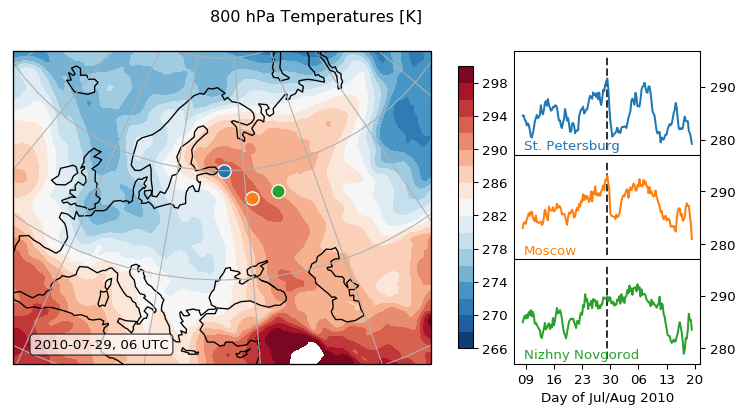

In [20]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

# width with cb: 6.48 / 0.9 = 7.2, leaving 2.8 for the temperature curves
fig = plt.figure(figsize=(10.0,4.32), dpi=96)

# Setup panels
gs = gridspec.GridSpec(3,4)
gs.update(hspace=0.0, wspace=0.0)

# Plot map
axm = plt.subplot(gs[:,:-1], projection=proj) # Map axes covers everything but the rightmost column
cs = axm.contourf(t_da.longitude, t_da.latitude, t_da.sel(time=showdate), 
            range(266,301,2),
            cmap='RdBu_r',
            transform=ccrs.PlateCarree(), # the projection of the data grid, here lat/lon, i.e. PlateCarree
)
axm.coastlines()
axm.gridlines(ylocs=range(15,76,15))

axm.set_xlim([-3.2e6, 3.2e6])
axm.set_ylim([-2.4e6, 2.4e6])
plt.colorbar(cs, fraction=0.1, shrink=0.9)

# Convert showdate to datetime, to then be able to format a string
datestr = pd.to_datetime(showdate).strftime('%Y-%m-%d, %H UTC')
axm.text(0.05, 0.05, datestr, transform=axm.transAxes, 
         bbox=dict(boxstyle="round", fc='w', alpha=0.7))

# Plot temperature time series, 3 weeks before and after the peak of the heat wave
showperiod = (showdate - np.timedelta64(21, 'D'), showdate + np.timedelta64(21, 'D'))
for sidx, station, name in zip(range(len(stations)), stations, stationnames):
    color = 'C%d' % sidx
    f = xr.open_dataset('d2s2/ei.ans.2010.800.%s.nc' % station)
    T = f['T'].squeeze() # Remove length-1 dimensions (lev,lat,lon), leaving only time in this case

    lat = f['lat'].values[0]
    lon = f['lon'].values[0]
    axm.scatter(lon, lat, s=100, facecolor=color, edgecolor='w', 
               linewidth=1, transform=ccrs.PlateCarree())    
    
    ax = plt.subplot(gs[sidx,-1])
    ax.plot([showdate, showdate], [278,296], color='0.2', linestyle='--') # vertical line
    slc = xr.ufuncs.logical_and(T.time >= showperiod[0], T.time <= showperiod[1])
    #T[slc].plot(color='red') 
    ax.plot(T.time[slc], T[slc], color)
    ax.yaxis.tick_right()
    
    if station == stations[-1]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax.set_xlabel('Day of Jul/Aug 2010')
    else:
        ax.set_xticks([])
    
    ax.text(0.05, 0.05, name, color=color, transform=ax.transAxes)

fig.suptitle('800 hPa Temperatures [K]')